In [1]:
import time
from pathlib import Path
from typing import Any, Generator, Literal

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt
from PIL import Image
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary


%matplotlib inline

In [2]:
class SimpsonsDataset(Dataset):
    def __init__(self, files_path, data_transforms):
        super().__init__()
        
        self.files_path = files_path
        self.transform = data_transforms

        self.labels = [path.parent.name for path in self.files_path]
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.labels)

    def __len__(self):
        return len(self.files_path)

    def __getitem__(self, idx):
        img_path = str(self.files_path[idx])
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        label_str = str(self.files_path[idx].parent.name)
        label = self.label_encoder.transform([label_str]).item()
        return image, label
    

In [3]:
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

batch_size = 128
input_size = 32

train_dir = Path("./content/the-simpsons-characters-dataset/simpsons_dataset/")

train_test_files_path = sorted(list(train_dir.rglob("*.jpg")))

train_test_labels = [path.parent.name for path in train_test_files_path]
train_files_path, test_files_path = train_test_split(
    train_test_files_path, test_size=0.20, stratify=train_test_labels
)

num_classes = len(np.unique(train_test_labels))
print(f"Quantity of classes: {num_classes}")

train_transform = tt.Compose(
    [
        tt.Resize((32, 32)),
        tt.ToTensor(),
        tt.Normalize(mean, std, inplace=False),
    ]
)

test_transform = tt.Compose(
    [
        tt.Resize((32, 32)),
        tt.ToTensor(),
        tt.Normalize(mean, std)
    ]
)

train_dataset = SimpsonsDataset(train_files_path, train_transform)
test_dataset = SimpsonsDataset(test_files_path, test_transform)


train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)


Quantity of classes: 42


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


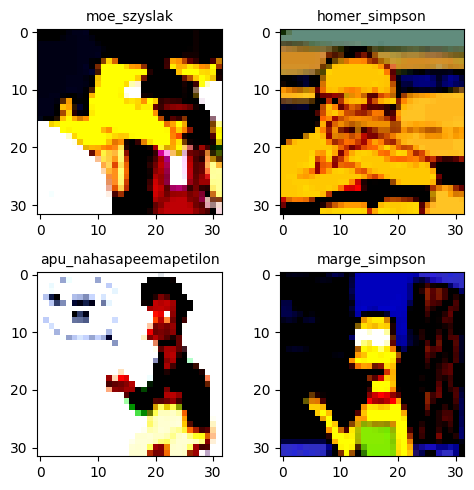

In [5]:
def img_is_color(img):
    if len(img.shape) == 3:
        # Check the color channels to see if they're all the same.
        c1, c2, c3 = img[:, :, 0], img[:, :, 1], img[:, :, 2]
        if (c1 == c2).all() and (c2 == c3).all():
            return True

    return False


def show_image_list(
    list_images,
    list_titles=None,
    list_cmaps=None,
    grid=True,
    num_cols=2,
    figsize=(20, 10),
    title_fontsize=30,
):
    assert isinstance(list_images, list)
    assert len(list_images) > 0
    assert isinstance(list_images[0], np.ndarray)

    if list_titles is not None:
        assert isinstance(list_titles, list)
        assert len(list_images) == len(list_titles), "%d imgs != %d titles" % (
            len(list_images),
            len(list_titles),
        )

    if list_cmaps is not None:
        assert isinstance(list_cmaps, list)
        assert len(list_images) == len(list_cmaps), "%d imgs != %d cmaps" % (
            len(list_images),
            len(list_cmaps),
        )

    num_images = len(list_images)
    num_cols = min(num_images, num_cols)
    num_rows = int(num_images / num_cols) + (1 if num_images % num_cols != 0 else 0)

    # Create a grid of subplots.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]

    for i in range(num_images):
        img = list_images[i]
        title = list_titles[i] if list_titles is not None else "Image %d" % (i)
        cmap = (
            list_cmaps[i]
            if list_cmaps is not None
            else (None if img_is_color(img) else "gray")
        )

        list_axes[i].imshow(img, cmap=cmap)
        list_axes[i].set_title(title, fontsize=title_fontsize)
        list_axes[i].grid(grid)

    for i in range(num_images, len(list_axes)):
        list_axes[i].set_visible(False)

    fig.tight_layout()
    _ = plt.show()


list_images = []
list_labels = []


for images, labels in train_dataloader:
    list_images.append(images[0].permute(1, 2, 0).cpu().detach().numpy())
    list_images.append(images[1].permute(1, 2, 0).cpu().detach().numpy())
    list_images.append(images[2].permute(1, 2, 0).cpu().detach().numpy())
    list_images.append(images[3].permute(1, 2, 0).cpu().detach().numpy())

    list_labels.append(
        train_dataset.label_encoder.inverse_transform([labels[0]]).item()
    )
    list_labels.append(
        train_dataset.label_encoder.inverse_transform([labels[1]]).item()
    )
    list_labels.append(
        train_dataset.label_encoder.inverse_transform([labels[2]]).item()
    )
    list_labels.append(
        train_dataset.label_encoder.inverse_transform([labels[3]]).item()
    )
    break

show_image_list(
    list_images, list_titles=list_labels, grid=False, figsize=(5, 5), title_fontsize=10
)


In [6]:
class Trainer(object):
    def __init__(
        self,
        model: nn.Module,
        train_dataloader: DataLoader,
        test_dataloader: DataLoader,
        optimizer: Any,
        loss: Any,
        device: Literal["cuda", "cpu"],
    ) -> None:
        self.model = model
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.optimizer = optimizer
        self.loss = loss
        self.device = device

    def _train_loop(self) -> float:
        self.model.train()

        corrects_quantity = 0
        total_len = 0

        for images, labels in self.train_dataloader:
            self.optimizer.zero_grad()

            images = images.type(torch.float32)
            images = images.to(self.device)
            total_len += len(labels)
            labels = F.one_hot(labels, num_classes=42)
            labels = labels.to(self.device)

            preds = self.model(images)

            loss = self.loss(
                preds.type(torch.float32),
                labels.type(torch.float32),
            )

            corrects = labels.argmax(dim=1) == preds.argmax(dim=1)

            corrects_quantity += int(corrects.sum())

            loss.backward()
            self.optimizer.step()

        return corrects_quantity / total_len

    def _test_loop(self) -> float:
        self.model.eval()
        corrects_quantity = 0
        labels_accum = torch.tensor([]).to(self.device)
        preds_accum = torch.tensor([]).to(self.device)
        total_len = 0

        with torch.no_grad():
            for images, labels in self.test_dataloader:
                self.optimizer.zero_grad()

                images = images.type(torch.float32)

                images = images.to(self.device)
                total_len += len(labels)
                labels = F.one_hot(labels, num_classes=42)
                labels = labels.to(self.device)

                preds = self.model(images)

                labels = labels.argmax(dim=1)
                preds = preds.argmax(dim=1)

                corrects = labels == preds
                corrects_quantity += int(corrects.sum())
                labels_accum = torch.cat(
                    (labels_accum.to(self.device), labels.to(self.device)), 0
                ).to(self.device)
                preds_accum = torch.cat(
                    (preds_accum.to(self.device), preds.to(self.device)), 0
                ).to(self.device)

        f1 = f1_score(labels_accum.tolist(), preds_accum.tolist(), average="weighted")

        return corrects_quantity / total_len, f1

    def train(self, epoch_num: int) -> Generator[nn.Module, None, None]:
        for epoch_no in range(epoch_num):
            start_time = time.time()
            train_accuracy = self._train_loop()
            time_of_train = time.time() - start_time

            start_time = time.time()
            test_accuracy, f1 = self._test_loop()
            time_of_test = time.time() - start_time

            print(f"Epoch: {epoch_no + 1}")
            print(f"Train accuracy: {train_accuracy:.4f}, time: {time_of_train:.2f}")
            print(f"Test accuracy: {test_accuracy:.4f}, time: {time_of_test:.2f}")

            if epoch_no == epoch_num - 1:
                print(f"\nTest F1 score: {f1:.4f}")

            yield self.model


In [7]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )

        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(
            planes,
            planes,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False,
        )

        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_planes,
            planes,
            kernel_size=1,
            bias=False,
        )

        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes,
            planes,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(
            planes,
            self.expansion * planes,
            kernel_size=1,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block,
        num_blocks,
        num_classes=42,
    ):
        super().__init__()

        self.in_planes = 64

        self.conv1 = nn.Conv2d(
            3,
            64,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False,
        )

        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


print(summary(ResNet18(), input_size=(batch_size, 3, 32, 32)))


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 42]                 --
├─Conv2d: 1-1                            [128, 64, 32, 32]         1,728
├─BatchNorm2d: 1-2                       [128, 64, 32, 32]         128
├─Sequential: 1-3                        [128, 64, 32, 32]         --
│    └─BasicBlock: 2-1                   [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-2             [128, 64, 32, 32]         128
│    │    └─Conv2d: 3-3                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-4             [128, 64, 32, 32]         128
│    │    └─Sequential: 3-5              [128, 64, 32, 32]         --
│    └─BasicBlock: 2-2                   [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-6                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-7             [128, 64, 32, 32]         

In [8]:
def train(
    model, device, train_dataloader, test_dataloader, optimizer, loss, epochs_num
) -> None:
    model = model
    model = model.to(device)

    trainer = Trainer(
        model,
        train_dataloader,
        test_dataloader,
        optimizer,
        loss,
        device,
    )

    for model in trainer.train(epochs_num):
        print()

    return model


In [9]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-5
NETWORK = ResNet18()
OPTIMIZER = torch.optim.Adam(
    NETWORK.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

DEVICE = "cuda"

LOSS = torch.nn.CrossEntropyLoss()
EPOCHS = 10


start_time = time.time()
trained_model = train(
    NETWORK, DEVICE, train_dataloader, test_dataloader, OPTIMIZER, LOSS, EPOCHS
)

print()
print(f"Total time: {time.time() - start_time:.2f}")


Epoch: 1
Train accuracy: 0.5914, time: 55.83
Test accuracy: 0.6606, time: 14.54

Epoch: 2
Train accuracy: 0.8202, time: 54.69
Test accuracy: 0.6887, time: 14.62

Epoch: 3
Train accuracy: 0.8949, time: 55.03
Test accuracy: 0.8107, time: 14.77

Epoch: 4
Train accuracy: 0.9322, time: 55.56
Test accuracy: 0.8519, time: 14.97

Epoch: 5
Train accuracy: 0.9585, time: 55.10
Test accuracy: 0.8814, time: 14.72

Epoch: 6
Train accuracy: 0.9740, time: 54.98
Test accuracy: 0.9334, time: 14.90

Epoch: 7
Train accuracy: 0.9804, time: 55.15
Test accuracy: 0.9359, time: 13.95

Epoch: 8
Train accuracy: 0.9810, time: 55.49
Test accuracy: 0.9122, time: 14.83

Epoch: 9
Train accuracy: 0.9857, time: 54.79
Test accuracy: 0.9494, time: 15.19

Epoch: 10
Train accuracy: 0.9841, time: 56.23
Test accuracy: 0.9544, time: 14.63

Test F1 score: 0.9552


Total time: 700.05
